# Cars Classification on the Stanford dataset

Train on vertical and horizontal masked images - i.e. images have one of the vertical halves masked out and the pixels above the diagonal maksed out

In [1]:
#cropped_cars_train_224_v2_diag2_nocrop

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Helper functions

In [3]:
def uprint(strng):
    print(f"\r{strng}".ljust(len(strng)+20), end='')

In [4]:
def mask_triangle(arr,which):
    try:
        m,n,*_=arr.shape
        k=np.abs(m-n)//2
        func=np.triu_indices_from if which=="upper" else np.tril_indices_from
        if len(arr.shape)>2:
            for c in range(arr.shape[2]):
                xind,yind=func(arr[:,:,c], k=k)
                arr[xind,yind,c]=0
        else:
            arr[func(arr,k=k)]=0

        return arr
    except Exception as e:
        print(arr.shape)
        raise(e)

In [5]:
def image_splitter2(src, dest, modes="vertical",two_folders=False):
    modes=modes if isinstance(modes, list) else list(modes)
    img_names=[x for x in os.listdir(src) if os.path.isfile(src/x)]
    if os.path.exists(dest):
        print(f"WARNING: {dest} directory already exists. Stopping pre-processing")
        return dest
    os.mkdir(dest)
    if two_folders:
        os.mkdir(dest/"one")
        os.mkdir(dest/"two")
    N=len(img_names)
    for c,im_name in enumerate(img_names,1):
        uprint(f"{c}/{N}")
        im_path=src/im_name
        img=plt.imread(im_path)
        r,c,*_=img.shape
        for i,mode in enumerate(modes,1):
            if mode=="vertical":
                img1,img2=img.copy(),img.copy()
                img1[:,c//2:]=0
                img2[:,:c//2]=0
            elif mode=="diagonal1":
                img1,img2=mask_triangle(img.copy(), "upper"),mask_triangle(img.copy(), "lower")
            elif mode=="diagonal2":
                img1,img2=np.flip(mask_triangle(np.flip(img), "upper")), np.flip(mask_triangle(np.flip(img), "lower"))        
            if two_folders:
                plt.imsave(dest/"one"/f"{im_path.stem}x{i}1{im_path.suffix}", img1)
                plt.imsave(dest/"two"/f"{im_path.stem}x{i}2{im_path.suffix}", img2)
            else:
                plt.imsave(dest/f"{im_path.stem}x{i}1{im_path.suffix}", img1)
                plt.imsave(dest/f"{im_path.stem}x{i}2{im_path.suffix}", img2)
    return dest

In [6]:
#src=pathlib.Path("data/cropped_cars_test_224")
#dest=pathlib.Path("data/cropped_cars_test_224_v2_diag2_nocrop")
#image_splitter2(src, dest, modes=["vertical", "diagonal1"], two_folders=False)

In [7]:
def create_ordered_files(suffixes,dir_name, fnames, labels=None):
    """
        Match the file names and the labels
        This is required because, for some datasets, the augmentations are pre-processed and stored in the train/test folders
        Returns df with `name` (file names) and `label` (category labels)
    """
    len_suf=len(suffixes)
    dir_name=pathlib.Path(dir_name)
    labels=labels if labels else []
    N=len(fnames)
    M=len_suf*N
    DUMMY=0
    df=pd.DataFrame(index=range(M), columns=["name"], dtype="str")
    new_fnames=[]
    ys=[]
    for i in range(N):
        fname=pathlib.Path(fnames[i])
        for j,suffix in enumerate(suffixes):
            new_fname=(fname.stem)+suffix+(fname.suffix)
            new_fnames.append(new_fname)
            #df.loc[idx,"label"]=DUMMY # slow, DONT do it
            if labels:
                ys.append(labels[i])          
    df["name"]=new_fnames
    df["label"]=ys if labels else DUMMY
    return df

In [8]:
def get_test_acc(model_path, model_name, test_path, ylabel_path):
    y_df=pd.read_csv(ylabel_path)
    y=torch.from_numpy(y_df["0"].values)
    learn=load_learner(model_path,model_name, test=ImageList.from_folder(test_path))
    preds,yhat = learn.get_preds(ds_type=DatasetType.Test)
    acc=accuracy(preds,y-1)
    return acc

In [9]:
def ensemble_acc2(preds,y, idxs):
    df=pd.DataFrame({"preds":preds.argmax(1), "fname":[idx.split('x')[0] for idx in idxs]}, index=idxs)
    yp=df.groupby("fname").agg(lambda x: pd.Series.mode(x)[0])["preds"].values
    yt=np.array(y)
    return (yt==yp).mean()

In [10]:
def ensemble_preds(preds,idxs):
    df=pd.DataFrame(np.asarray(preds), index=idxs)
    df["fname"]=[idx.split('x')[0] for idx in idxs]
    yp=df.groupby("fname").mean().values
    return torch.from_numpy(yp)

In [11]:
def predict_on_test(model_path, model_name,test_path, suffixes, int_suffix, yolo_prefix, yolo_root, tta=False):
    fname_col="name"
    
    fnames=[f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path,f))]
    print(f"No of test files: {len(fnames)}")
    
    src=pathlib.Path(test_path)
    parent,child=src.parent, src.name
    dest=pathlib.Path(parent/(yolo_prefix+str(child)+int_suffix))
    yolo_root=pathlib.Path(yolo_root)
    #!rm -r {dest} # if it already exists
    
    # UNCOMMENT THIS BLOCK WHILE USING THE VERY FIRST TIME
    tmp_destination=pathlib.Path(parent/(yolo_prefix+str(child)))
    print(f"Yolo out dir: {tmp_destination}")
    print(f"{dest}")
    crop_cars2(src,tmp_destination, yolo_root)
    image_splitter2(tmp_destination, dest, modes=["vertical", "diagonal1"], two_folders=False)
    
    test_df=create_ordered_files(suffixes,dest,fnames,labels=None)
    learner=load_learner(model_path,model_name, test=ImageList.from_df(test_df, path=dest))
    pred_func=learner.TTA if tta else learner.get_preds
    preds,_=pred_func(ds_type=DatasetType.Test)
    preds2=ensemble_preds(preds,test_df[fname_col])
    return preds2, pd.DataFrame({"file_names":fnames})

In [12]:
def get_yolo_model(yolo_root):
    args={"yolo":str(yolo_root.resolve()/"yolo-coco")}
    labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
    LABELS = open(labelsPath).read().strip().split("\n")
    weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
    configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath) #load YOLO object detector trained on COCO dataset (80 classes)
    return net

In [13]:
def extract_car(im_path, net, offset=10):
    args={
    "image":str(im_path),
    "confidence":0.5,
    "threshold":0.3
    }
    
    image = cv2.imread(args["image"])
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > args["confidence"]:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])
    
    if boxes:
        largest_bb=np.argmax([box[-2]*box[-1] for box in boxes])
        box=boxes[largest_bb]

        if classIDs[largest_bb] not in [2,7]: # car/truck categories
            print(f"Largest object is not a car for {im_path} at {box}")
            return slice(0,W), slice(0,H)
        
        (x, y),(w, h)=(max(box[0]-offset,0), max(0,box[1]-offset)), (box[2]+2*offset, box[3]+2*offset)
        return slice(x,x+w),slice(y,y+h)
    
    else: # no car detected
        return slice(0,W), slice(0,H)

In [14]:
def crop_cars2(src,dest, yolo_root): # without tqdm
    print(f"Src dir: {src} \nDest dir:{dest}")
    imgs=[src/img for img in os.listdir(src) if os.path.isfile(src/img) and not img.endswith(".pkl")]
    N=len(imgs)
    model=get_yolo_model(yolo_root)
    if os.path.exists(dest):
        print(f"WARNING: {dest} directory already exists. Stopping YOLO pre-processing")
        return dest
    os.mkdir(dest)
    for c,img_path in enumerate(imgs,1):
        uprint(f"Processing {c}/{N} - {img_path.name}")
        bb=extract_car(img_path, model, offset=10)
        img=plt.imread(img_path)
        car=img[bb[1],bb[0]]
        dest_path=dest/img_path.name
        plt.imsave(dest_path, car)

In [15]:
#!rm -r {root/"cropped_cars_test_tmp"}

In [16]:
#root=pathlib.Path("data")
#path=root/"cars_test"
#yolo_root=root/"yolo-object-detection"

#dest=root/"cropped_cars_test_tmp"
#crop_cars2(path,dest)

Setup GPU

In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [18]:
import torch
torch.cuda.device_count(), torch.cuda.get_device_name(0), torch.cuda.get_device_properties(0)

(1,
 'GeForce RTX 2080 Ti',
 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68))

In [19]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2,cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio

Hyperparameters and constants to be used for the training and evaluation

In [20]:
class HyperParams():
    valid_pct=0.2 # percent of data to use as validation
    random_seed=42
    data_root="data" # parent directory of the dataset
    original_train_folder="cars_train" # the directory for the uprocessed raw images (provided by user)
    train_folder="cropped_cars_train_224_v2_diag2_nocrop" # the dir of images that are processed and used for training the model (created by code)
    train_label_file="train_labels.txt" # original train labels provided by Stanford Cars dataset
    test_folder="cars_test"
    test_label_file="test_labels.csv" # created by me from the mat file from Stanford site for the dataset 
    
    yolo_prefix="cropped_" # prefix for folders created by yolo-car-cropping
    yolo_dir="data/yolo-object-detection"
    bs=40 # batch size
    img_size=224
    
    model_file_name="MODEL-final-stanford-cars-1x42-tfms-yolo-224-noar-noaug-res152.pkl"
    
    save1_name="final-stanford-cars-0x42-tfms-yolo-224-noar-noaug-res152" # temporary saves
    save2_name="final-stanford-cars-1x42-tfms-yolo-224-noar-noaug-res152" 

In [21]:
opts=HyperParams()

suffixes=["x11","x12", "x21", "x22"]

In [22]:
# convenient variables for different paths
root=pathlib.Path(opts.data_root)
original_path=root/pathlib.Path(opts.original_train_folder)
path=root/pathlib.Path(opts.train_folder)
original_path, path

(PosixPath('data/cars_train'),
 PosixPath('data/cropped_cars_train_224_v2_diag2_nocrop'))

Preprocess images in `original_path` and store resultant images in `path`. Processed images in `path` are used for training the model.  
Note that `vertical_splitter` will create the `dest` folder. It fails if it already exists

In [23]:
src=original_path
dest=path
yolo_root=pathlib.Path(opts.yolo_dir)
tmp_destination=root/pathlib.Path(opts.yolo_prefix+opts.original_train_folder)
print(f"Yolo out dir: {tmp_destination}")
crop_cars2(original_path,tmp_destination, yolo_root)
image_splitter2(tmp_destination, dest, modes=["vertical", "diagonal1"], two_folders=False)

Yolo out dir: data/cropped_cars_train
Src dir: data/cars_train 
Dest dir:data/cropped_cars_train


PosixPath('data/cropped_cars_train_224_v2_diag2_nocrop')

In [24]:
files=!ls {path}
files[:10], len(files)

(['00001x11.jpg',
  '00001x12.jpg',
  '00001x21.jpg',
  '00001x22.jpg',
  '00002x11.jpg',
  '00002x12.jpg',
  '00002x21.jpg',
  '00002x22.jpg',
  '00003x11.jpg',
  '00003x12.jpg'],
 32579)

In [25]:
# train labels dataframe
labels_df=pd.read_csv(root/opts.train_label_file, header=None)
display(labels_df.head(), labels_df.tail())

,0
0,14
1,3
2,91
3,134
4,106


,0
8139,78
8140,196
8141,163
8142,112
8143,17


In [26]:
len(labels_df)

8144

Match the file names and the labels. This is required because, for some datasets, the augmentations are pre-processed and stored in the train/test folders

In [27]:
fnames=[f for f in os.listdir(original_path) if os.path.isfile(os.path.join(original_path,f)) and not f.endswith(".pkl")]
print(f"No of train images: {len(fnames)}")
    
train_df=create_ordered_files(suffixes,dest,fnames,labels=labels_df[0].values.tolist())
display(train_df.head(), train_df.tail())

No of train images: 8144


,name,label
0,00001x11.jpg,14
1,00001x12.jpg,14
2,00001x21.jpg,14
3,00001x22.jpg,14
4,00002x11.jpg,3


,name,label
32571,08143x22.jpg,112
32572,08144x11.jpg,17
32573,08144x12.jpg,17
32574,08144x21.jpg,17
32575,08144x22.jpg,17


Create the databunch (fastai's dataloader)

In [28]:
tfms=[]

In [29]:
data = (
    ImageList.from_df(train_df, path=path)
        .split_by_rand_pct(valid_pct=opts.valid_pct, seed=opts.random_seed) 
        .label_from_df("label")
        #.label_from_func(partial(get_label, labels_df))
        #.add_test_folder(opts.test_folder)
        .transform(tfms, size=opts.img_size)
        .databunch(bs=opts.bs)
        .normalize(imagenet_stats)
       )

Sanity check if the train images and labels are matched correctly

In [30]:
data.train_ds.x.items

array(['data/cropped_cars_train_224_v2_diag2_nocrop/00001x11.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/00001x12.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/00001x21.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/00001x22.jpg', ...,
       'data/cropped_cars_train_224_v2_diag2_nocrop/08143x22.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/08144x11.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/08144x21.jpg',
       'data/cropped_cars_train_224_v2_diag2_nocrop/08144x22.jpg'], dtype='<U57')

In [31]:
min(data.train_ds.y.items), max(data.train_ds.y.items) # fastai maps the labels to [0, n_classes-1]

(0, 195)

In [32]:
data.train_ds.y.items

array([ 13,  13,  13,  13, ..., 111,  16,  16,  16])

In [33]:
nm="08143x22.jpg"
train_df[train_df.name==nm]

,name,label
32571,08143x22.jpg,112


View a batch of images (with augmentation if sepecified)

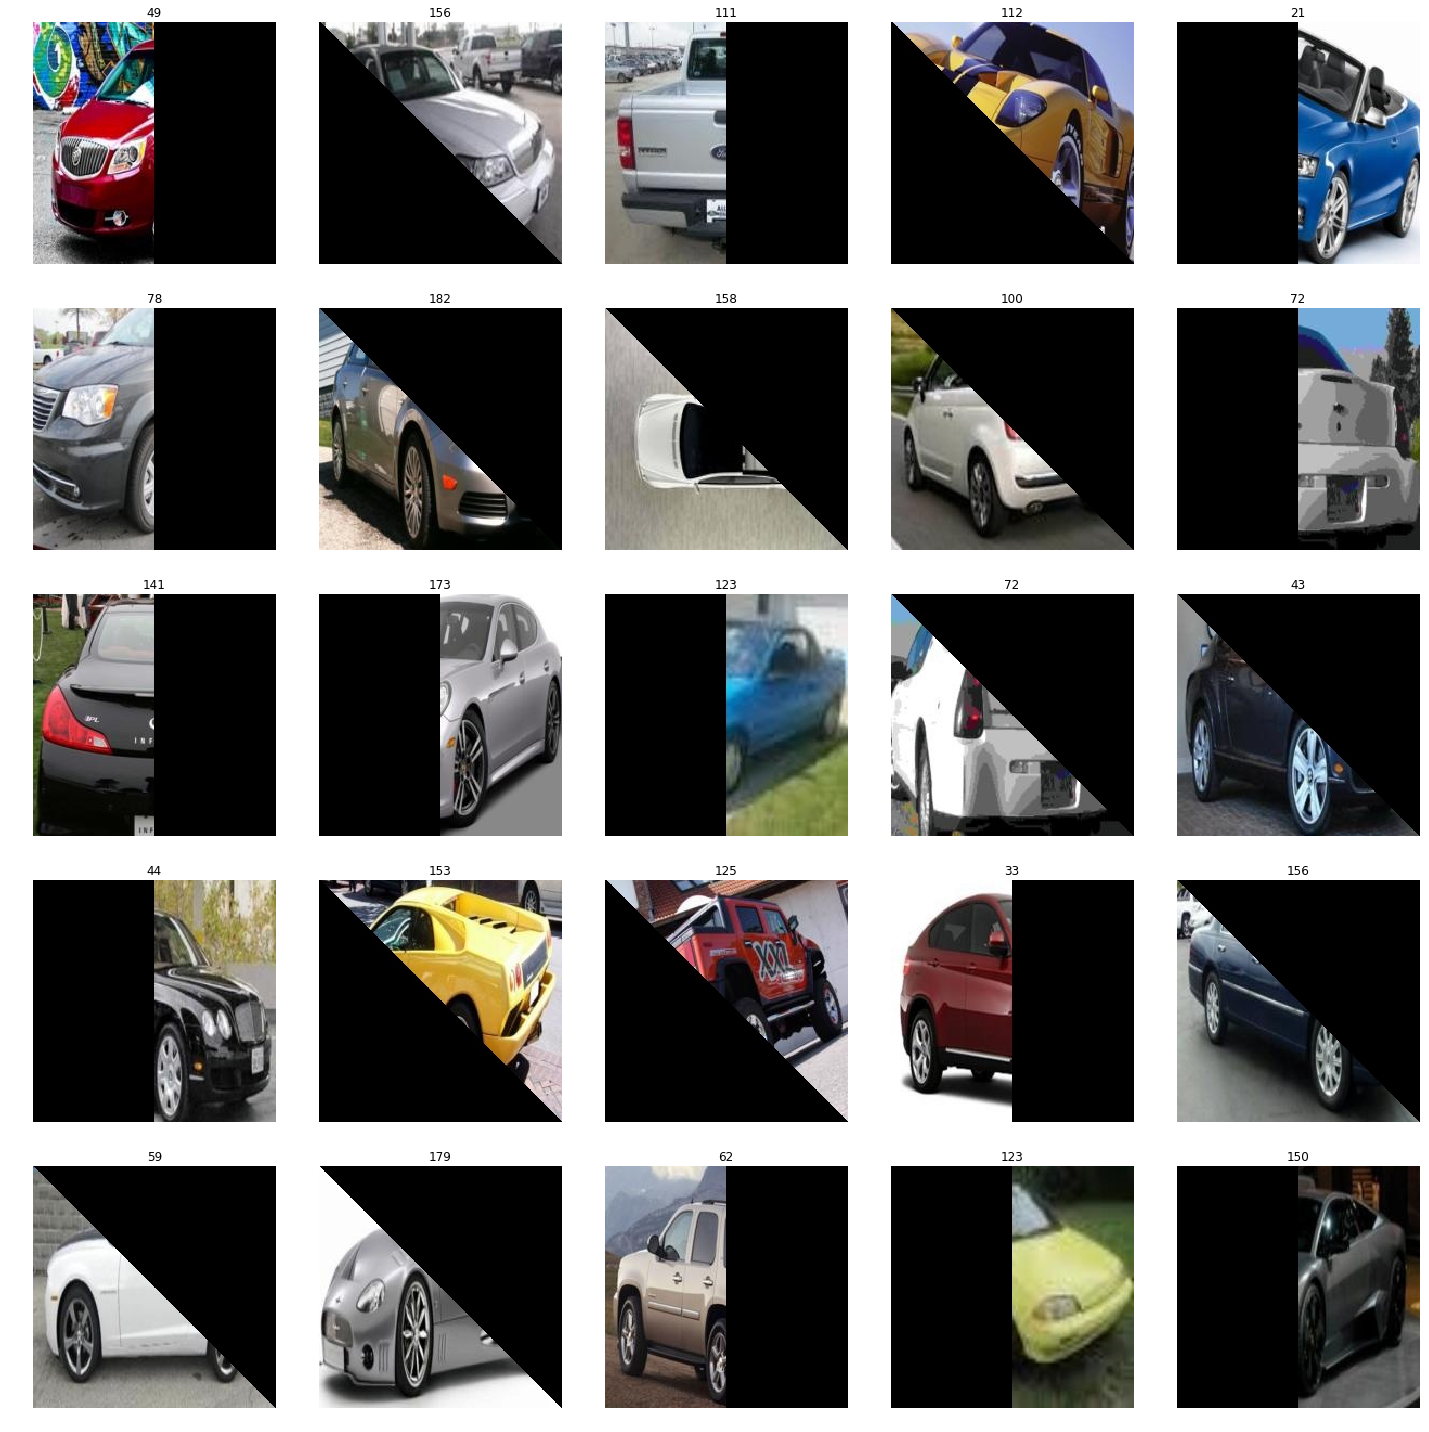

In [34]:
data.show_batch()

In [35]:
c1,c2=len(data.classes),data.c
assert c1==c2
print(f"Class names: {data.classes} \n\n Class count:{c1}")  

Class names: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196] 

 Class count:196


Create a learner (model) using pretrained resnet152 and fine tune only the last layer, keeping other fixed, for 4 epochs 

In [44]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.390722,2.769954,0.328933,03:22
1,2.072171,1.576629,0.581120,03:20
2,1.293665,1.045279,0.709747,05:28
3,0.870338,0.942883,0.738143,06:32


In [45]:
preds,y,loss=learn.get_preds(with_loss=True)
acc=accuracy(preds,y)
acc

tensor(0.7381)

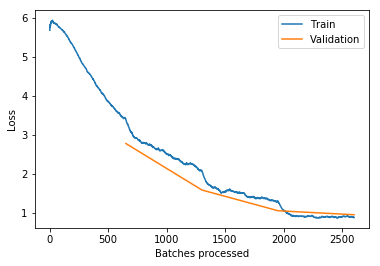

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save(opts.save1_name)

Visualize the images which the model got wrong

In [38]:
interp=ClassificationInterpretation.from_learner(learn)
losses,idxs=interp.top_losses()
assert len(data.valid_ds)==len(losses)==len(idxs)

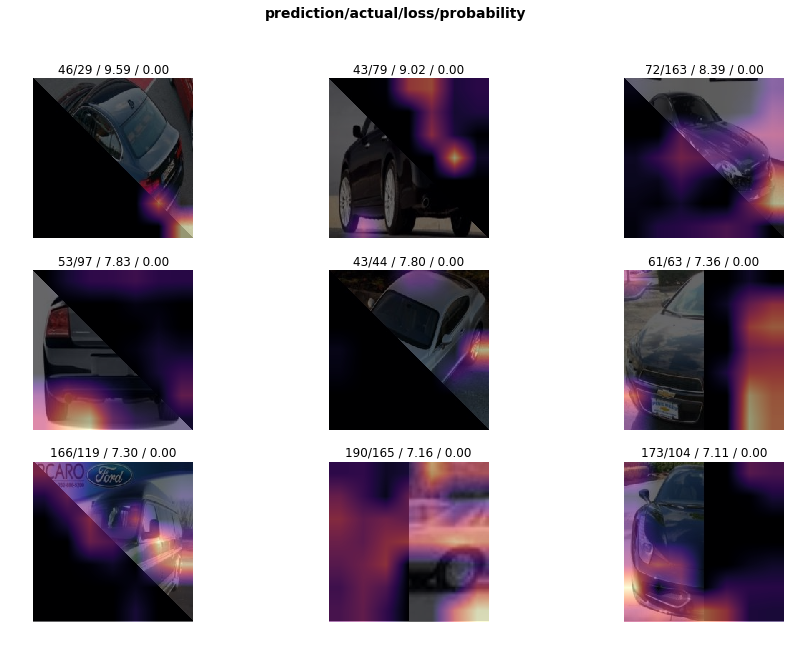

In [39]:
interp.plot_top_losses(9, figsize=(15,10))

Train all the layers of the model now

In [40]:
learn.unfreeze()
learn.lr_find() # finds the best cyclic-learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


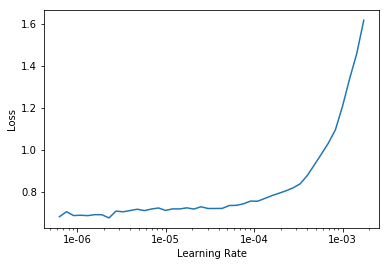

In [41]:
learn.recorder.plot()

Train the model (all layers) for 15 epochs, with differntial learning rate - lower lr (`1e-5`) for the early layers of the resnet and higher lr (`1e-4`) for the later layers

In [42]:
learn.fit_one_cycle(15, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.743060,0.852093,0.761934,05:36
1,0.598035,0.693415,0.812279,06:00
2,0.473812,0.524377,0.858327,06:04
3,0.305218,0.431823,0.883653,05:52
4,0.199880,0.341586,0.910361,05:57
5,0.138474,0.332239,0.915733,05:58
6,0.096014,0.286394,0.926324,06:00
7,0.063237,0.273211,0.928012,06:01
8,0.035562,0.232693,0.939524,05:59
9,0.029298,0.220948,0.944436,06:02


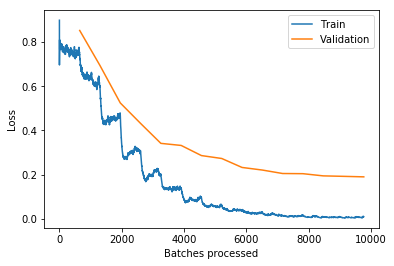

In [43]:
learn.recorder.plot_losses()

In [44]:
learn.save(opts.save2_name)

Export the model with all its parameters and settings so that it can be used for inference on a different device

In [45]:
learn.export(opts.model_file_name)
learn.path

PosixPath('data/cropped_cars_train_224_v2_diag2_nocrop')

Evaluate the model on test data

Without TTA (Test Time Augmentation)

In [46]:
model_path="data/cropped_cars_train_224_v2_diag2_nocrop"
model_name="MODEL-final-stanford-cars-1x42-tfms-yolo-224-noar-noaug-res152.pkl" # inside the `model_path` directory above
test_path="data/cars_test"

int_suffix="_224_v2_diag2_nocrop"
yolo_prefix="cropped_"
tta=False

yolo_root="data/yolo-object-detection"

suffixes=["x11","x12","x21","x22"]

preds2,test_names_df=predict_on_test(model_path, model_name,test_path, suffixes,int_suffix, yolo_prefix, yolo_root, tta=tta)

In [47]:
display(test_names_df.head(), test_names_df.tail())

,file_names
0,00001.jpg
1,00002.jpg
2,00003.jpg
3,00004.jpg
4,00005.jpg


,file_names
8036,08037.jpg
8037,08038.jpg
8038,08039.jpg
8039,08040.jpg
8040,08041.jpg


In [48]:
# NOTE: test labels are assumed to be from 1 to 196, as in the original Stanford Cars dataset, NOT [0,195]

ylabel_path="data/test_labels.csv" # test labels are assumed to be from 1 to 196, as in the original Stanford Cars dataset
y_df=pd.read_csv(ylabel_path)
y=torch.from_numpy(y_df["label"].values)-1 # -1 because fastai maps labels to [0, n_classes-1]
print(f"No of labels: {y.shape[0]}")

acc=accuracy(preds2, y)
print(f"Test accuracy: {acc.item():.3f}")

No of labels: 8041
Test accuracy: 0.863
